In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB:
    # Code to download the necessary files (e.g. solutions, test funcs)
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main
        !unzip /content/main.zip 'ARENA_2.0-main/chapter1_transformers/exercises/*'
        sys.path.append("/content/ARENA_2.0-main/chapter1_transformers/exercises")
        os.remove("/content/main.zip")
        os.rename("ARENA_2.0-main/chapter1_transformers", "chapter1_transformers")
        os.rmdir("ARENA_2.0-main")

         # Install packages
        %pip install einops
        %pip install jaxtyping
        %pip install transformer_lens
        %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
        %pip install s3fs
        %pip install omegaconf
        %pip install git+https://github.com/CindyXWu/devinterp-automata.git
        %pip install torch-ema

        !curl -o /content/main.zip https://codeload.github.com/CindyXWu/devinterp-automata/zip/refs/heads/main
        !unzip -o /content/main.zip -d /content/

        sys.path.append("/content/devinterp-automata/")
        os.remove("/content/main.zip")

        os.chdir("chapter1_transformers/exercises")
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

    CHAPTER = r"chapter1_transformers"
    CHAPTER_DIR = r"./" if CHAPTER in os.listdir() else os.getcwd().split(CHAPTER)[0]
    EXERCISES_DIR = CHAPTER_DIR + f"{CHAPTER}/exercises"
    sys.path.append(EXERCISES_DIR)

In [2]:
from dotenv import load_dotenv
import plotly.express as px
from typing import List, Union, Optional, Dict, Tuple
from jaxtyping import Int, Float

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
import numpy as np
import pandas as pd
import einops
import re
import functools
from tqdm import tqdm
from IPython.display import display
import webbrowser
import gdown
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformer_lens.utils import to_numpy

import circuitsvis as cv
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# For Dashiell's groups code
from copy import deepcopy
from functools import reduce
from itertools import product
import math
import numpy as np
from operator import mul
import torch

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAIN = __name__ == "__main__"

import wandb
from pathlib import Path
import os
import yaml
import s3fs
from omegaconf import OmegaConf

from di_automata.config_setup import *
from di_automata.constructors import (
    construct_model,
    create_dataloader_hf,
)
from di_automata.tasks.data_utils import take_n
import plotly.io as pio

# AWS
load_dotenv()
AWS_KEY, AWS_SECRET = os.getenv("AWS_KEY"), os.getenv("AWS_SECRET")
s3 = s3fs.S3FileSystem(key=AWS_KEY, secret=AWS_SECRET)

/Users/cindy/anaconda3/envs/devinterp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cindy/anaconda3/envs/devinterp/lib/python3.12/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_type" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/cindy/anaconda3/envs/devinterp/lib/python3.12/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_save_method" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
def imshow_attention(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [4]:
update_layout_set = {"xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor", "showlegend", "xaxis_tickmode", "yaxis_tickmode", "margin", "xaxis_visible", "yaxis_visible", "bargap", "bargroupgap", "coloraxis_showscale", "xaxis_tickangle"}
import torch as t

def imshow(tensor: t.Tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    facet_labels = kwargs_pre.pop("facet_labels", None)
    border = kwargs_pre.pop("border", False)
    return_fig = kwargs_pre.pop("return_fig", False)
    text = kwargs_pre.pop("text", None)
    xaxis_tickangle = kwargs_post.pop("xaxis_tickangle", None)
    static = kwargs_pre.pop("static", False)
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    if "color_continuous_midpoint" not in kwargs_pre:
        kwargs_pre["color_continuous_midpoint"] = 0.0
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.imshow(to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        # Weird thing where facet col wrap means labels are in wrong order
        if "facet_col_wrap" in kwargs_pre:
            facet_labels = reorder_list_in_plotly_way(facet_labels, kwargs_pre["facet_col_wrap"])
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label
    if border:
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    if text:
        if tensor.ndim == 2:
            # if 2D, then we assume text is a list of lists of strings
            assert isinstance(text[0], list)
            assert isinstance(text[0][0], str)
            text = [text]
        else:
            # if 3D, then text is either repeated for each facet, or different
            assert isinstance(text[0], list)
            if isinstance(text[0][0], str):
                text = [text for _ in range(len(fig.data))]
        for i, _text in enumerate(text):
            fig.data[i].update(
                text=_text,
                texttemplate="%{text}",
                textfont={"size": 12}
            )
    # Very hacky way of fixing the fact that updating layout with new tickangle only applies to first facet by default
    if xaxis_tickangle is not None:
        n_facets = 1 if tensor.ndim == 2 else tensor.shape[0]
        for i in range(1, 1+n_facets):
            xaxis_name = "xaxis" if i == 1 else f"xaxis{i}"
            fig.layout[xaxis_name]["tickangle"] = xaxis_tickangle
    return fig if return_fig else fig.show(renderer=renderer, config={"staticPlot": static})

def reorder_list_in_plotly_way(L: list, col_wrap: int):
    '''
    Helper function, because Plotly orders figures in an annoying way when there's column wrap.
    '''
    L_new = []
    while len(L) > 0:
        L_new.extend(L[-col_wrap:])
        L = L[:-col_wrap]
    print(f"Reordered labels: {L_new}")
    return L_new

In [5]:
DI_ROOT = Path("/content/devinterp-automata-main/") if IN_COLAB else Path("../")
config_file_path = DI_ROOT / f"scripts/configs/slt_config.yaml"
slt_config = OmegaConf.load(config_file_path)

with open(DI_ROOT / f"scripts/configs/task_config/{slt_config.dataset_type}.yaml", 'r') as file:
    task_config = yaml.safe_load(file)

In [6]:
OmegaConf.set_struct(slt_config, False) # Allow new configuration values to be added
# Because we are in Colab and not VSCode, here is where you want to edit your config values
task_config["n"] = 4
slt_config["task_config"] = task_config

# Convert OmegaConf object to MainConfig Pydantic model for dynamic type validation - NECESSARY DO NOT SKIP
pydantic_config = PostRunSLTConfig(**slt_config)
# Convert back to OmegaConf object for compatibility with existing code
slt_config = OmegaConf.create(pydantic_config.model_dump())

print(task_config["dataset_type"])

dihedral


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Run path and name for easy referral later
run_path = f"{slt_config.entity_name}/{slt_config.wandb_project_name}"
run_name = slt_config.run_name
print(run_name)

dihedral_TF_LENS_LR0.0001_its15000_layers3_seqlen25_nstates4_prob1None_nactionsNone


In [8]:
# Get run information
api = wandb.Api(timeout=3000)
run_list = api.runs(
    path=run_path,
    filters={
        "display_name": run_name,
        "state": "finished",
        },
    order="created_at", # Default descending order so backwards in time
)
assert run_list, f"Specified run {run_name} does not exist"
run_api = run_list[slt_config.run_idx]
try: history = run_api.history()
except: history = run_api.history
loss_history = history["Train Loss"]
accuracy_history = history["Train Acc"]
steps = history["_step"]
time = run_api.config["time"]

In [9]:
def get_config() -> MainConfig:
    """"
    Manually get config from run as artifact.
    WandB also logs automatically for each run, but it doesn't log enums correctly.
    """
    artifact = api.artifact(f"{run_path}/config:{run_name}_{time}")
    data_dir = artifact.download()
    config_path = Path(data_dir) / "config.yaml"
    return OmegaConf.load(config_path)

In [10]:
config = get_config()

# Set total number of unique samples seen (n). If this is not done it will break LLC estimator.
slt_config.rlct_config.sgld_kwargs.num_samples = slt_config.rlct_config.num_samples = config.rlct_config.sgld_kwargs.num_samples
slt_config.nano_gpt_config = config.nano_gpt_config

wandb:   1 of 1 files downloaded.  


In [11]:
def restore_state_single_cp(cp_idx: int) -> dict:
    """Restore model state from a single checkpoint.
    Used in _load_logits_states() and _calculate_rlct().

    Args:
        idx_cp: index of checkpoint.

    Returns:
        model state dictionary.
    """
    idx = cp_idx * config.rlct_config.ed_config.eval_frequency * slt_config.skip_cps
    print(f"Getting checkpoint {idx}")
    print(config.model_save_method)
    match config.model_save_method:
        case "wandb":
            artifact = api.artifact(f"{run_path}/states:idx{idx}_{run_name}_{time}")
            data_dir = artifact.download()
            state_path = Path(data_dir) / f"states_{idx}.torch"
            states = torch.load(state_path)
        case "aws":
            with s3.open(f'{config.aws_bucket}/{run_name}_{time}/states_{idx}.pth', mode='rb') as file:
                states = torch.load(file, map_location=device)
    return states["model"]

In [12]:
current_directory = Path().absolute()
logits_file_path = current_directory.parent / f"di_automata/logits_{run_name}_{time}"
print(logits_file_path)

/Users/cindy/ml-projects/devinterp-automata/di_automata/logits_dihedral_TF_LENS_LR0.0001_its15000_layers3_seqlen25_nstates4_prob1None_nactionsNone_02_26_04_17


In [13]:
ed_loader = create_dataloader_hf(config, deterministic=True) # Make sure deterministic to see same data

In [14]:
def display_layer_heads(att, batch_idx=0):
  display(cv.attention.attention_patterns(
      tokens=list_of_strings(inputs[batch_idx,...]),
      attention=att[batch_idx,...],
      attention_head_names=[f"L0H{i}" for i in range(4)],
  ))
  # 0 is toggle action
  # 1 is drive action
  print(inputs[batch_idx,...])
  print(labels[batch_idx,...])

def list_of_strings(tensor):
  return tensor.numpy().astype(str).tolist()


def display_layer_heads_batch(att: torch.Tensor, cache: ActivationCache, toks: list[str]):
  """TODO: refactor"""
  cv.attention.from_cache(
    cache = cache,
    tokens = toks,
    batch_idx = list(range(10)),
    attention_type = "info-weighted",
    radioitems = True,
    return_mode = "view",
    batch_labels = lambda batch_idx, str_tok_list: format_sequence(str_tok_list, dataset.str_tok_labels[batch_idx]),
    mode = "small",
  )

Dashiell code setup to get labels for examples

In [15]:
from functools import reduce
from itertools import accumulate

class DihedralElement:

    def __init__(self, rot: int, ref: int, n: int):
        self.n = n
        self.rot = rot % n
        self.ref = ref % 2

    def __repr__(self):
        return str((self.rot, self.ref))

    def __hash__(self):
        return hash(str(self))

    @property
    def sigma(self):
        return self.rot, self.ref

    @classmethod
    def full_group(cls, n):
        return [
            DihedralElement(r, p, n) for r, p in product(range(n), [0, 1])
        ]

    @property
    def order(self):
        if self.ref:
            return 2
        elif self.rot == 0:
            return 0
        elif (self.n % self.rot) == 0:
            return self.n // self.rot
        else:
            return math.lcm(self.n, self.rot) // self.rot

    @property
    def inverse(self):
        if self.ref:
            return deepcopy(self)
        else:
            return DihedralElement(self.n - self.rot, self.ref, self.n)

    def __mul__(self, other):
        if (not isinstance(other, DihedralElement)) or (other.n != self.n):
            raise ValueError(
                'Can only multiply a dihedral rotation with another dihedral rotation'
            )
        if self.ref:
            rot = self.rot - other.rot
        else:
            rot = self.rot + other.rot
        return DihedralElement(rot, self.ref + other.ref, self.n)

    def __pow__(self, x: int):
        if x == -1:
            return self.inverse
        elif x == 0:
            return DihedralElement(0, 0, self.n)
        elif x == 1:
            return deepcopy(self)
        else:
            return reduce(mul, [deepcopy(self) for _ in range(x)])

    def index(self) -> int:
        return self.rot * self.ref + self.rot


def generate_subgroup(generators, n):
    group_size = 0
    all_elements = set(generators)
    while group_size < len(all_elements):
        group_size = len(all_elements)
        rotations = [DihedralElement(*p, n) for p in all_elements]
        for r1, r2 in product(rotations, repeat=2):
            r3 = r1 * r2
            all_elements.add(r3.sigma)
    return list(all_elements)


def dihedral_conjugacy_classes(n: int):

    conj_classes = [(0, 0), (0, 1)]
    if n % 2 == 1:
        m = (n - 1) // 2
    else:
        m = (n - 2) // 2
        conj_classes += [((2, 0), (0, 1)), ((2, 1), (1, 1))]
    conj_classes += [(i, 0) for i in range(1, m+1)]
    return conj_classes


class DihedralIrrep:

    def __init__(self, n: int, conjugacy_class):
        self.n = n
        self.conjugacy_class = conjugacy_class
        self.group = DihedralElement.full_group(n)

    def _trivial_irrep(self):
        return {r.sigma: torch.ones((1,)) for r in self.group}

    def _reflection_irrep(self):
        return {r.sigma: (-1**r.ref) * torch.ones((1,)) for r in self.group}

    def _subgroup_irrep(self, sg):
        return {r.sigma: 1 if r.sigma in sg else -1 for r in self.group}

    def _matrix_irrep(self, k):
        mats = {}
        mats[(0, 0)] = torch.eye(2)
        ref = torch.tensor([[1.0, 0.0], [0.0, -1.0]], dtype=torch.float32)
        mats[(0, 1)] = ref
        two_pi_n = 2 * torch.pi / self.n
        for idx in range(1, self.n):
            sin = np.sin(two_pi_n * idx * k)
            cos = np.cos(two_pi_n * idx * k)
            m = torch.tensor([[cos, -1.0 * sin], [sin, cos]], dtype=torch.float32)
            mats[(idx, 0)] = m
            mats[(idx, 1)] = ref @ m
        return mats

    def matrix_representations(self):
        if self.conjugacy_class == (0, 0):
            return self._trivial_irrep()
        elif self.conjugacy_class == (0, 1):
            return self._reflection_irrep()
        elif self.conjugacy_class[1] == 0:
            return self._matrix_irrep(self.conjugacy_class[0])
        elif (
            isinstance(self.conjugacy_class[0], tuple) and
            isinstance(self.conjugacy_class[1], tuple)
        ):
            subgroup = generate_subgroup(self.conjugacy_class, self.n)
            return self._subgroup_irrep(subgroup)
        else:
            raise ValueError(
                f'Somehow {self.conjugacy_class} is not a proper conjugacy class....'
            )


class ProductDihedralIrrep:

    def __init__(self, n: int, m: int, conjugacy_classes):

        assert len(conjugacy_classes) == m

        self.m = m
        self.n = n
        self.conjugacy_class = conjugacy_classes
        self.group = [element for element in product(DihedralElement.full_group(n), repeat=m)]
        self.irreps = [
            DihedralIrrep(n, conj_class).matrix_representations() for conj_class in conjugacy_classes
        ]

    def matrix_representations(self):

        reps = {}

        for elements in self.group:
            key = tuple(el.sigma for el in elements)
            matrices = [self.irreps[i][el] for i, el in enumerate(key)]
            reps[key] = reduce(torch.kron, matrices)
        return reps

In [16]:
GROUP_SIZE = 4
group = DihedralElement.full_group(GROUP_SIZE)
translation = {
    (0,0):0,
    (1,0):1,
    (2,0):2,
    (3,0):3,
    (0,1):4,
    (1,1):5,
    (2,1):6,
    (3,1):7,
}


def actions_to_labels(tensor, dtype: str):
    actions = {
        0: DihedralElement(0, 1, GROUP_SIZE),
        1: DihedralElement(1, 0, GROUP_SIZE)
    }
    action_list = []
    for i in tensor:
        if i ==  torch.tensor(0):
            action_list.append(actions[0])
        else:
            action_list.append(actions[1])
    states = accumulate(action_list, mul)
    dtype = torch.float32 if dtype == "float" else torch.int32
    return torch.tensor([translation[s.sigma] for s in states], dtype=dtype)

In [17]:
actions_to_labels(torch.tensor([0,1,1,0,1,0,0,0,1,1,1]), dtype="int")

tensor([4, 7, 6, 2, 3, 7, 3, 7, 6, 5, 4], dtype=torch.int32)

# Get checkpoints

In [18]:
# Pre-form
cp_idx_0 = 20
state_0 = restore_state_single_cp(cp_idx_0)
model_0, _ = construct_model(config)
model_0.load_state_dict(state_0)

# Form 1
cp_idx_1 = 500
state_1 = restore_state_single_cp(cp_idx_1)
model_1, _ = construct_model(config)
model_1.load_state_dict(state_1)

# Form 2
cp_idx_2 = 1400
state_2 = restore_state_single_cp(cp_idx_2)
model_2, _ = construct_model(config)
model_2.load_state_dict(state_2)

Getting checkpoint 160
aws
Getting checkpoint 4000
aws
Getting checkpoint 11200
aws


<All keys matched successfully>

In [19]:
# Pass data through
for data in take_n(ed_loader, 1):
    inputs = data["input_ids"]
    labels = data["label_ids"]
    break

logits_0, cache_0 = model_0.run_with_cache(inputs)
logits_1, cache_1 = model_1.run_with_cache(inputs)
logits_2, cache_2 = model_2.run_with_cache(inputs)

# Behavioural evaluations

Make a dataset with only cyclic behaviour - only 1s. See how this performs.

In [20]:
all1 = torch.ones((25), dtype=torch.int32)
all0 = torch.zeros((25), dtype=torch.int32)
all1_label = (torch.cumsum(all1, dim=0)) % 4
all0_label = torch.tensor([4,0]*12+[4], dtype=torch.int32)
print(all1_label)
print(all0_label)

# All zeros except a single one at one position
all_zero_except1 = deepcopy(all0)
all_zero_except1[8] = 1
all_zero_except1_label = actions_to_labels(all_zero_except1, dtype="int")
print(all_zero_except1_label)


# All ones except a single zero at one position
all_one_except1 = deepcopy(all1)
all_one_except1[8] = 0
all_one_except1_label = actions_to_labels(all_one_except1, dtype="int")
print(all_one_except1_label)

tensor([1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0,
        1])
tensor([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0,
        4], dtype=torch.int32)
tensor([4, 0, 4, 0, 4, 0, 4, 0, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5,
        1], dtype=torch.int32)
tensor([1, 2, 3, 0, 1, 2, 3, 0, 4, 7, 6, 5, 4, 7, 6, 5, 4, 7, 6, 5, 4, 7, 6, 5,
        4], dtype=torch.int32)


## Early in training
Model_0 has seen 400 iterations. It is stark that it already has learned parity (or to predict on a sequence of all zeros)

In [21]:
def plot_tensor_heatmap(stacked_tensor, title='Comparison of Tensor Positions', figsize=(10, 6), cmap='coolwarm'):
    """
    Plots a heatmap of a stacked tensor.

    Args:
        stacked_tensor (Tensor): A stacked PyTorch tensor to plot.
        title (str, optional): Title of the heatmap. Defaults to 'Comparison of Tensor Positions'.
        figsize (tuple, optional): Figure size. Defaults to (10, 6).
        cmap (str, optional): Colormap for the heatmap. Defaults to 'coolwarm'.
        xticklabels (bool or list, optional): X-axis tick labels. Defaults to True (automatic).
        yticklabels (list, optional): Y-axis tick labels. If None, defaults to index numbers.

    Returns:
        None. Displays a matplotlib plot.
    """
    # Ensure the stacked_tensor is moved to CPU and converted to a numpy array
    tensor_matrix = stacked_tensor.cpu().numpy()

    # Plotting
    plt.figure(figsize=figsize)
    sns.heatmap(tensor_matrix, annot=True, cmap=cmap, fmt='d', linewidths=.5)
    plt.title('Comparison of Tensor Positions')
    plt.ylabel('Tensor')
    plt.xlabel('Position')
    
    plt.xticks(np.arange(0.5, len(all1_label.numpy()), 1), np.arange(1, 26))
    plt.yticks(np.arange(0.5, len(stacked_tensor), 1), ['all_1_label', 'predicted_all_1s', 'all_0_label', 'predicted_all_0s', 'all_0s_except_1_label', 'predicted_all_0s_except_1', 'all_1s_except_1_label', 'predicted_all_1s_except_1'], rotation=0)
    plt.show()

torch.Size([25])
all one labels tensor([1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0,
        1])
predicted all ones tensor([1, 2, 1, 5, 1, 2, 6, 2, 1, 2, 2, 2, 6, 2, 3, 5, 1, 2, 1, 2, 2, 2, 1, 7,
        1])
all zero labels tensor([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0,
        4], dtype=torch.int32)
predicted all zeros tensor([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 4, 4, 4,
        4])
tensor([4, 0, 4, 0, 4, 0, 4, 0, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5,
        1], dtype=torch.int32)
predicted all 0s except 1 tensor([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 4,
        4])
tensor([1, 2, 3, 0, 1, 2, 3, 0, 4, 7, 6, 5, 4, 7, 6, 5, 4, 7, 6, 5, 4, 7, 6, 5,
        4], dtype=torch.int32)
predicted all 1s except 1 tensor([1, 2, 1, 5, 1, 2, 6, 2, 3, 5, 6, 2, 6, 2, 3, 5, 1, 2, 1, 2, 1, 2, 1, 5,
        1])


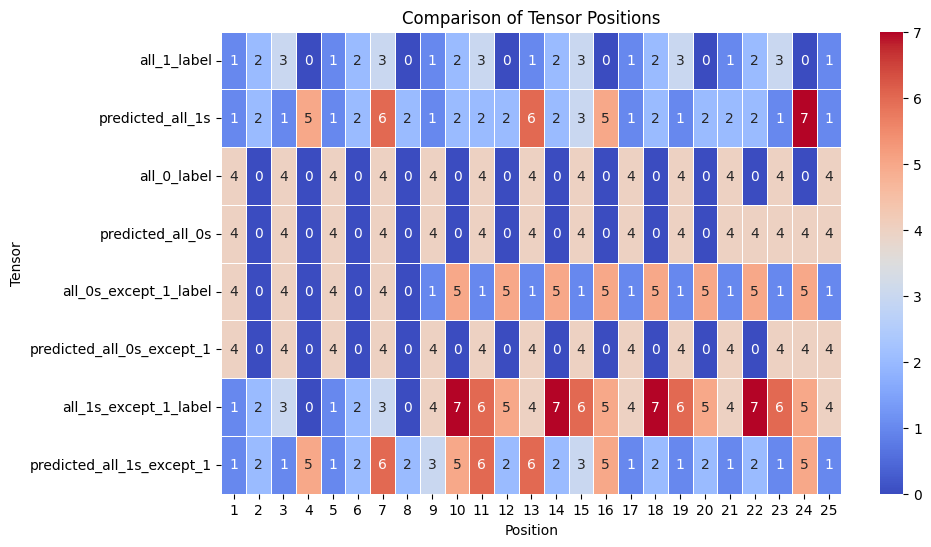

In [22]:
l_all1_0, cache_all1_0 = model_0.run_with_cache(all1)
l_all0_0, cache_all0_0 = model_0.run_with_cache(all0)
pred_all1_0 = torch.argmax(l_all1_0, dim=-1).squeeze().cpu()
pred_all0_0 = torch.argmax(l_all0_0, dim=-1).squeeze().cpu()
print(pred_all0_0.shape)
print("all one labels", all1_label)
print("predicted all ones", pred_all1_0)
print("all zero labels", all0_label)
print("predicted all zeros", pred_all0_0)

l_all_zero_except1_0, c_zero_except1_0 = model_0.run_with_cache(all_zero_except1)
l_all_one_except1_0 , c_all_one_except1_0 = model_0.run_with_cache(all_one_except1)
pred_all_zero_except1_0 = torch.argmax(l_all_zero_except1_0, dim=-1).squeeze().cpu()
pred_all_one_except1_0 = torch.argmax(l_all_one_except1_0, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_0)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_0)

# Convert tensors to numpy arrays for easier handling with seaborn
tensor_matrix = torch.stack([all1_label, pred_all1_0, all0_label, pred_all0_0, all_zero_except1_label, pred_all_zero_except1_0, all_one_except1_label, pred_all_one_except1_0])
plot_tensor_heatmap(tensor_matrix)

## Form 1

torch.Size([25])
all one labels tensor([1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0,
        1])
predicted all ones tensor([1, 2, 3, 0, 1, 2, 3, 0, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5,
        1])
all zero labels tensor([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0,
        4], dtype=torch.int32)
predicted all zeros tensor([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0,
        4])
tensor([4, 0, 4, 0, 4, 0, 4, 0, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5,
        1], dtype=torch.int32)
predicted all 0s except 1 tensor([4, 0, 4, 0, 4, 0, 4, 0, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5,
        1])
tensor([1, 2, 3, 0, 1, 2, 3, 0, 4, 7, 6, 5, 4, 7, 6, 5, 4, 7, 6, 5, 4, 7, 6, 5,
        4], dtype=torch.int32)
predicted all 1s except 1 tensor([1, 2, 3, 0, 1, 2, 3, 0, 4, 0, 3, 0, 4, 0, 3, 0, 4, 5, 4, 5, 1, 5, 1, 5,
        4])


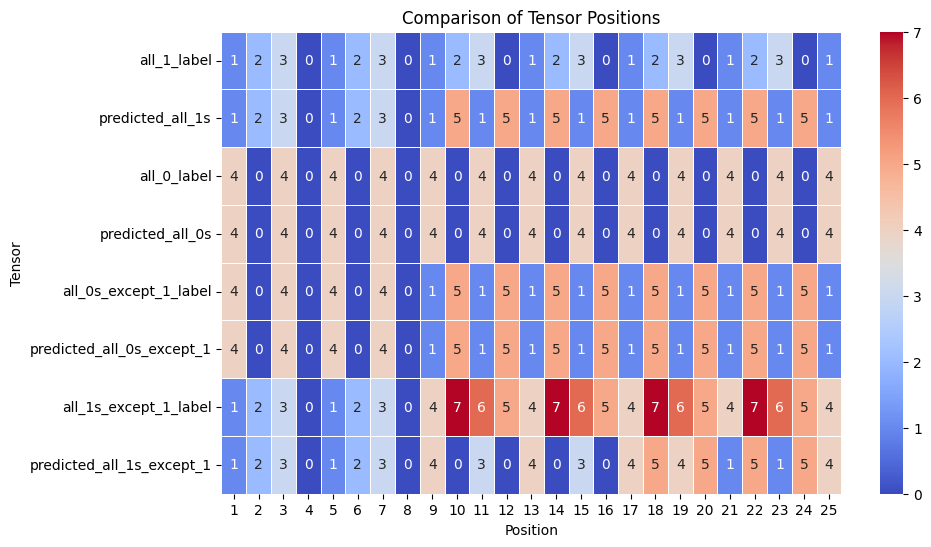

In [23]:
l_all1_1, cache_all1_1 = model_1.run_with_cache(all1)
l_all0_1, cache_all0_1 = model_1.run_with_cache(all0)
pred_all1_1 = torch.argmax(l_all1_1, dim=-1).squeeze().cpu()
pred_all0_1 = torch.argmax(l_all0_1, dim=-1).squeeze().cpu()
print(pred_all0_1.shape)
print("all one labels", all1_label)
print("predicted all ones", pred_all1_1)
print("all zero labels", all0_label)
print("predicted all zeros", pred_all0_1)

l_all_zero_except1_1, c_zero_except1_1 = model_1.run_with_cache(all_zero_except1)
l_all_one_except1_1 , c_all_one_except1_1 = model_1.run_with_cache(all_one_except1)
pred_all_zero_except1_1 = torch.argmax(l_all_zero_except1_1, dim=-1).squeeze().cpu()
pred_all_one_except1_1 = torch.argmax(l_all_one_except1_1, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_1)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_1)

# Convert tensors to numpy arrays for easier handling with seaborn
tensor_matrix = torch.stack([all1_label, pred_all1_1, all0_label, pred_all0_1, all_zero_except1_label, pred_all_zero_except1_1, all_one_except1_label, pred_all_one_except1_1])
plot_tensor_heatmap(tensor_matrix)

## Form 2

all one labels tensor([1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0,
        1])
predicted all ones tensor([1, 2, 3, 0, 1, 2, 3, 0, 1, 5, 4, 7, 6, 2, 3, 7, 3, 7, 4, 7, 3, 7, 3, 7,
        3])
all zero labels tensor([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0,
        4], dtype=torch.int32)
predicted all zeros tensor([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0,
        4])
tensor([4, 0, 4, 0, 4, 0, 4, 0, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5,
        1], dtype=torch.int32)
predicted all 0s except 1 tensor([4, 0, 4, 0, 4, 0, 4, 0, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 4, 0, 4, 0,
        4])
tensor([1, 2, 3, 0, 1, 2, 3, 0, 4, 7, 6, 5, 4, 7, 6, 5, 4, 7, 6, 5, 4, 7, 6, 5,
        4], dtype=torch.int32)
predicted all 1s except 1 tensor([1, 2, 3, 0, 1, 2, 3, 0, 4, 7, 6, 2, 3, 0, 6, 2, 3, 7, 3, 7, 3, 7, 3, 7,
        3])


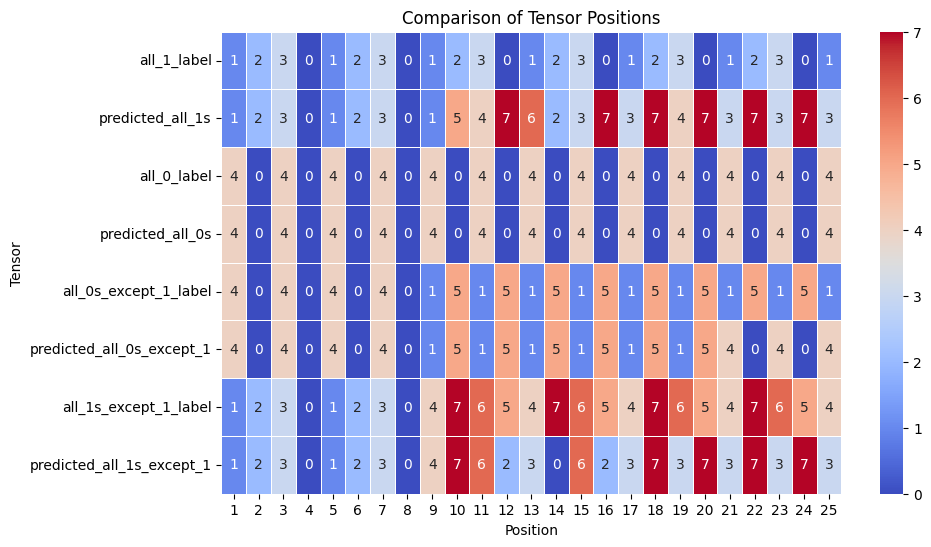

In [24]:
l_all1_2, cache_all1_2 = model_2.run_with_cache(all1)
l_all0_2, cache_all0_2 = model_2.run_with_cache(all0)
pred_all1_2 = torch.argmax(l_all1_2, dim=-1).squeeze().cpu()
pred_all0_2 = torch.argmax(l_all0_2, dim=-1).squeeze().cpu()
print("all one labels", all1_label)
print("predicted all ones", pred_all1_2)
print("all zero labels", all0_label)
print("predicted all zeros", pred_all0_2)

l_all_zero_except1_2, c_zero_except1_2 = model_2.run_with_cache(all_zero_except1)
l_all_one_except1_2 , c_all_one_except1_2 = model_2.run_with_cache(all_one_except1)
pred_all_zero_except1_2 = torch.argmax(l_all_zero_except1_2, dim=-1).squeeze().cpu()
pred_all_one_except1_2 = torch.argmax(l_all_one_except1_2, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_2)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_2)

# Convert tensors to numpy arrays for easier handling with seaborn
tensor_matrix = torch.stack([all1_label, pred_all1_2, all0_label, pred_all0_2, all_zero_except1_label, pred_all_zero_except1_2, all_one_except1_label, pred_all_one_except1_2])
plot_tensor_heatmap(tensor_matrix)